<a href="https://colab.research.google.com/github/tentenNT/6s_polarization/blob/master/raw_to_polimg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive/')
%ls "drive/My Drive/ColabNotebooks/image_add"
%cd "drive/My Drive/ColabNotebooks/image_add"


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
data/  image_add.ipynb  out/  out.mp4  out.webm  raw_to_polimg.ipynb
/content/drive/My Drive/ColabNotebooks/image_add


In [0]:
# 必要なパッケージのインポート
import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from IPython.display import HTML
import base64
import io

# ディレクトリ
dataDir = "./data" # 入力データのディレクトリ
outDir  = "./out"  # 出力データのディレクトリ

# 出力ディレクトリがあるかを確認，なければ作成
if not os.path.exists(outDir):
    os.mkdir(outDir)

# ファイル名
#=======================================
originalInputFileName     = "50mm_raw_oki.avi" # <-- ここを自分で用意した画像に変えること
compaInputFileName = "rgb_oki.avi"
#=======================================
originalInputFileBaseName, originalInputFileExt = os.path.splitext(originalInputFileName)
resizedInputFileName  = originalInputFileBaseName + '_resized' + originalInputFileExt

# 画像のフルパスの設定（要 os パッケージ）
originalInputFilePath = os.path.join(dataDir, originalInputFileName)
resizedInputFilePath  = os.path.join(outDir, resizedInputFileName)
compaInputFilePath = os.path.join(dataDir, compaInputFileName)
# 各種パラメータ
#=======================================
resizedWidth = 512 # リサイズ後の画像の幅 [px]
FRAMES = 40
ENTIRE_FRAMES = FRAMES * 2
MEANS = 5
ROW = 1024
COL = 1224
COLAB = True
#=======================================



In [0]:
def f_to_uint(img):
  img = np.round(bg_added)
  img = img.astype('uint8')
  return img

In [0]:
def imshow_resized(img, size=0.2):
  img = np.fix(img)
  print(np.amax(img))
  img =  np.clip(img, 0, 255)
  print(np.amax(img))
  img = img.astype('uint8')
  if(COLAB):
    cv2_imshow(cv2.resize(img, None, fx=size, fy=size))

In [0]:
# avi読み込み
def vread(T=30):
    cap = cv2.VideoCapture(originalInputFilePath)
    ret, frame = cap.read()
    print(frame.shape)
    row, col, _ = frame.shape
    image_frames = np.array([])
    for i in range(T):
      cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()

      if ret:
          frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
          image_frames = np.append(image_frames, frame)
    image_frames =  np.reshape(image_frames, (T, row, col))
    cap.release()
    return image_frames
image_frames = vread(T = ENTIRE_FRAMES)
print(image_frames.shape) # => (例): (21, 600, 600, 3)
print(image_frames.dtype)

(2048, 2448, 3)
(80, 2048, 2448)
float64


In [0]:
def video_rec(image_frames):
  height = image_frames.shape[1]
  width = image_frames.shape[2]
  resize = 2
  size = (1224//resize, 1024//resize)
  fourcc = cv2.VideoWriter_fourcc(*'MP4V')
  video = cv2.VideoWriter('./out.mp4', fourcc, 15, size, False)

  for img in image_frames:
      img_resized = cv2.resize(img, size)
      img_uint8 = img_resized.astype(np.uint8)
      imshow_resized(img_uint8)
      video.write(img_uint8)

  video.release()

In [0]:
def video_play():
  !ffmpeg -i ./out.mp4 -vcodec vp9 ./out.webm -y
  video = io.open('./out.webm', 'r+b').read()
  encoded = base64.b64encode(video)
  return(HTML(data='''<video width=image_frames.shape[2] height=image_frames.shape[1] controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii'))))

In [0]:
I_90 = image_frames[:,0::2,0::2]
I_45 = image_frames[:, 0::2, 1::2]
I_135 = image_frames[:, 1::2, 0::2]
I_0 = image_frames[:, 1::2, 1::2]
print(I_0.shape)
print(I_0.dtype)

(80, 1024, 1224)
float64


In [0]:
C_1 = I_0 - I_90
C_2 = I_45 - I_135
A = np.power(C_1, 2)
B = np.power(C_2, 2)
R = np.sqrt(A+B)

I_a = R/2
I_b = (I_0+I_45+I_90+I_135)/4
I_max = I_b+I_a
I_min = I_b-I_a
I_max = np.clip(I_max, 0, 255)
I_min = np.clip(I_min, 0, 255)
I_b = np.clip(I_b, 0, 255)
rho = I_a / I_b * 255
theta = (np.arctan2(C_2, C_1) + np.pi)/(np.pi*2)*255

139.0
139.0


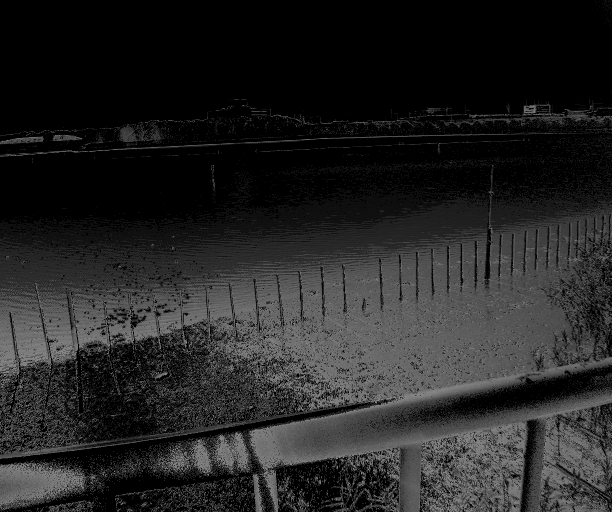

139


In [0]:
def thresh_image(img, lower, upper):
  threshed_img = np.where(img < lower, 0, img)
  threshed_img = np.where(img > upper, 0, threshed_img)
  return threshed_img

rho_threshed = thresh_image(rho, 50, 140)
imshow_resized(rho_threshed[0], 0.5)

In [0]:
#video_rec(rho_threshed)
#video_play()

In [0]:
# 検出回数が回数で出てくるようにした
def calculate_bgadded(image_frames_loops, ignore = 0,  image_shape = (1024, 1224), history = 5, nmixture = 10, backgroundRatio = 0.95 ,noiseSigma = 0):
  bg_added = np.zeros(image_shape)
  #fgbg = cv2.createBackgroundSubtractorMOG2(varThreshold = 25, detectShadows=False)
  fgbg = cv2.bgsegm.createBackgroundSubtractorMOG(history = history, nmixtures = nmixture, backgroundRatio = backgroundRatio, noiseSigma = noiseSigma)
  i = 0
  for img in image_frames_loops:
      i += 1
      img = np.fix(img)
      img = img.astype('uint8')
      # print(i)
      fgmask = fgbg.apply(img)
      # imshow_resized(fgmask)
      if(i > ignore):
        bg_added += fgmask
  # bg_addedを出現回数に応じて0 < 1に正規化
  bg_added /= 255.0
  bg_added = np.fix(bg_added)
  return bg_added

(1024, 1224)
(1024, 1224)
2550.0
255.0


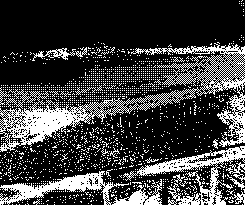

255


In [0]:
bg_added = calculate_bgadded(rho_threshed)
#bg_added /= np.amax(bg_added)
print(bg_added.shape)
#bg_added = thresh_image(bg_added, 2, 10)
print(bg_added.shape)
bg_added *= 255
imshow_resized(bg_added)

2550.0
255.0


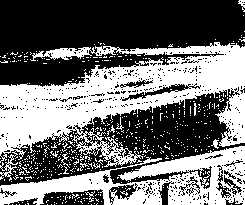

255


In [0]:
kernel = np.ones((3,3),np.uint8)
# bg_added = cv2.dilate(bg_added, kernel, iterations = 1)
bg_added = cv2.morphologyEx(bg_added, cv2.MORPH_CLOSE, kernel)
# bg_added = cv2.morphologyEx(bg_added, cv2.MORPH_OPEN, kernel)

imshow_resized(bg_added)

765.0
255.0


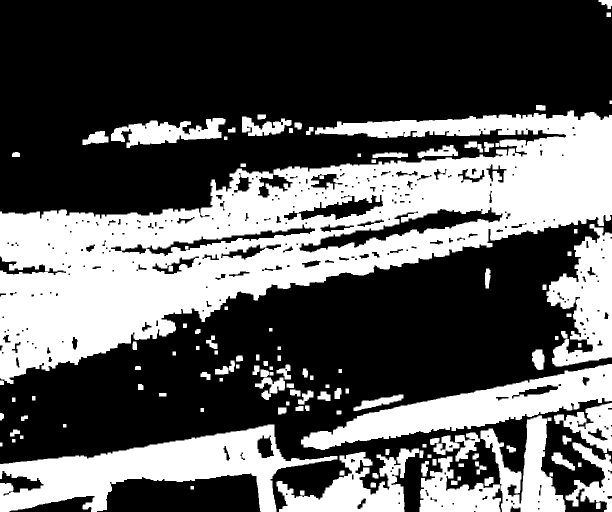

255


In [0]:
kernel = np.ones((7,7),np.uint8)
# bg_added = cv2.dilate(bg_added, kernel, iterations = 1)
# bg_added = cv2.morphologyEx(bg_added, cv2.MORPH_CLOSE, kernel)
bg_added = cv2.morphologyEx(bg_added, cv2.MORPH_OPEN, kernel)

imshow_resized(bg_added, 0.5)

In [0]:
#rect
ret,thresh = cv2.threshold(bg_added,1,255,cv2.THRESH_BINARY)
imshow_colab(thresh, "gray")
thresh = f_to_uint(thresh)

# Finding contours for the thresholded image
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# create hull array for convex hull points
hull = []
 
# calculate points for each contour
for i in range(len(contours)):
    # creating convex hull object for each contour
    hull.append(cv2.convexHull(contours[i], False))

# create an empty black image
drawing = np.zeros((thresh.shape[0], thresh.shape[1], 3), np.uint8)
 
# draw contours and hull points
for i in range(len(contours)):
    color_contours = (0, 255, 0) # green - color for contours
    color = (255, 0, 0) # blue - color for convex hull
    # draw ith contour
    imshow_colab(cv2.drawContours(drawing, contours, -1, color_contours, 1, 8, hierarchy))
    # draw ith convex hull object
    imshow_colab(cv2.drawContours(drawing, hull, -1, color, 1, 8))
    #imshow_colab(cv2.drawContours(drawing, hull, i, color, 1, 8))

In [0]:
# 画像の平均化
def mean_images(image_frames):
    i = 0
    row = image_frames.shape[1]
    col = image_frames.shape[2]
    img_sum = np.zeros((row, col))
    image_frames_means = np.array([])

    for img in image_frames:
      i += 1
      img_sum += img
      if(i % MEANS == 0):
        print(i)
        img_sum /= MEANS
        image_frames_means = np.append(image_frames_means, img_sum)
        img_sum = np.zeros((row, col))
    image_frames_means = np.reshape(image_frames_means, (ENTIRE_FRAMES // MEANS, row, col))

    imshow_resized(image_frames_means[0])
    return image_frames_means

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80


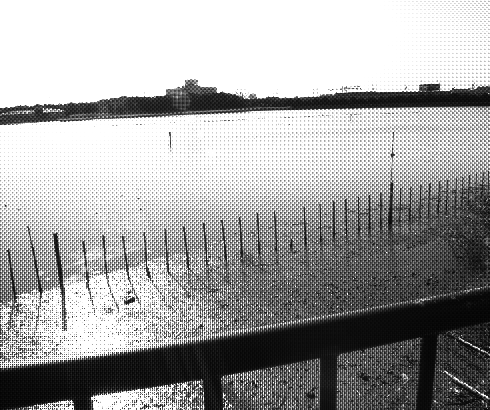

(16, 2048, 2448)


In [0]:
image_frames_means = mean_images(image_frames)
print(image_frames_means.shape)

I_90 = image_frames_means[:,0::2,0::2]
I_45 = image_frames_means[:, 0::2, 1::2]
I_135 = image_frames_means[:, 1::2, 0::2]
I_0 = image_frames_means[:, 1::2, 1::2]

C_1 = I_0 - I_90
C_2 = I_45 - I_135
A = np.power(C_1, 2)
B = np.power(C_2, 2)
R = np.sqrt(A+B)

I_a = R/2
I_b = (I_0+I_45+I_90+I_135)/4
I_max = I_b+I_a
I_min = I_b-I_a
I_max = np.clip(I_max, 0, 255)
I_min = np.clip(I_min, 0, 255)
I_b = np.clip(I_b, 0, 255)

rho_means = I_a / I_b * 255
theta_means = (np.arctan2(C_2, C_1) + np.pi)/(np.pi*2)*255

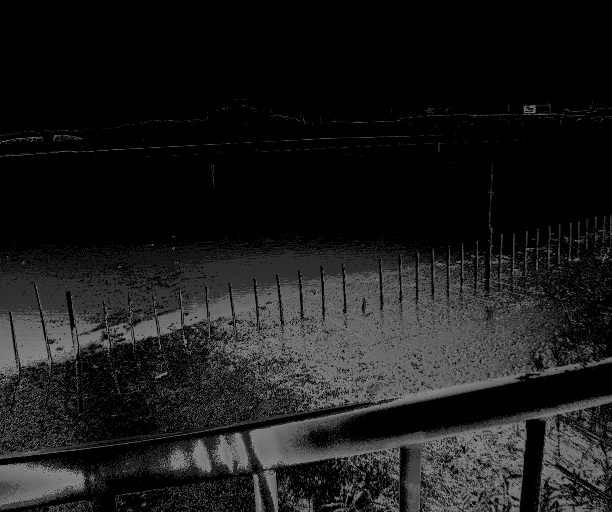

In [0]:
lower = 80
upper = 140
rho_threshed_means = np.where(rho_means < lower, 0, rho_means)
rho_threshed_means = np.where(rho_means > upper, 0, rho_threshed_means)
imshow_resized(rho_threshed_means[0], 0.5)

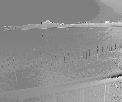

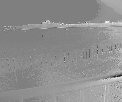

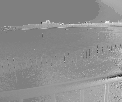

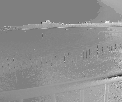

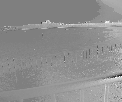

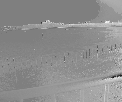

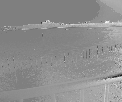

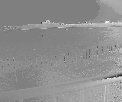

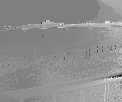

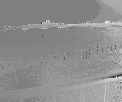

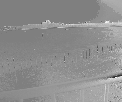

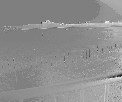

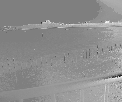

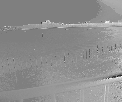

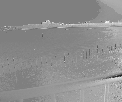

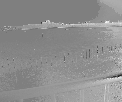

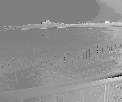

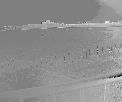

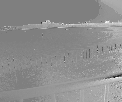

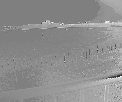

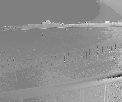

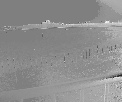

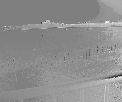

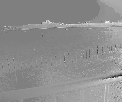

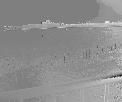

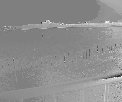

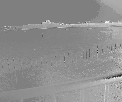

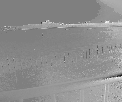

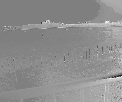

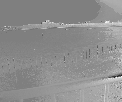

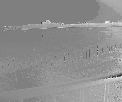

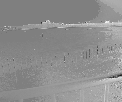

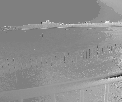

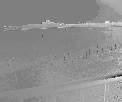

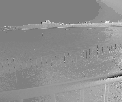

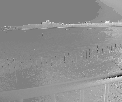

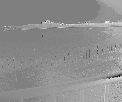

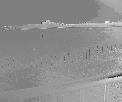

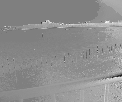

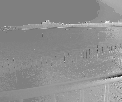

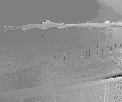

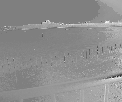

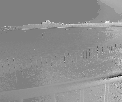

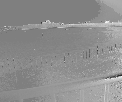

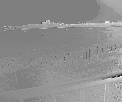

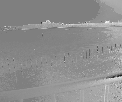

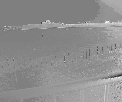

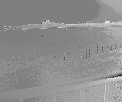

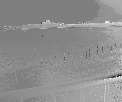

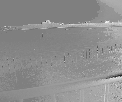

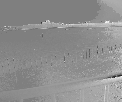

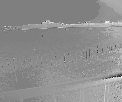

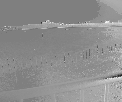

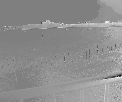

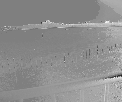

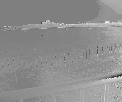

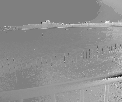

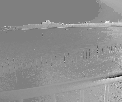

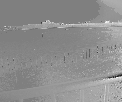

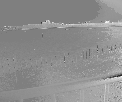

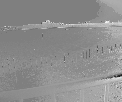

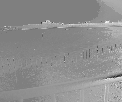

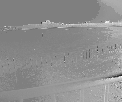

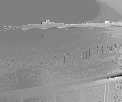

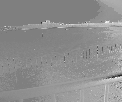

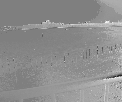

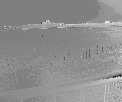

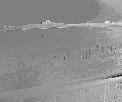

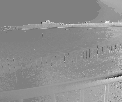

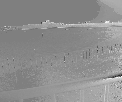

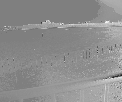

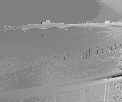

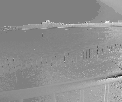

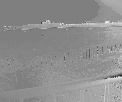

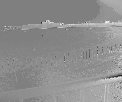

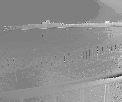

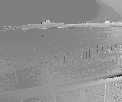

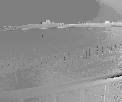

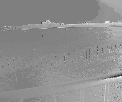

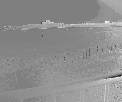

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [0]:
video_rec(theta)
video_play()

In [0]:
# avi読み込み
def vread(T=30):
    cap = cv2.VideoCapture(compaInputFilePath)
    ret, frame = cap.read()
    print(frame.shape)
    row, col, _ = frame.shape
    image_frames = np.array([])
    for i in range(T):
      cap.set(cv2.CAP_PROP_POS_FRAMES, i)
      ret, frame = cap.read()

      if ret:
          frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
          image_frames = np.append(image_frames, frame)
    image_frames =  np.reshape(image_frames, (T, row, col))
    cap.release()
    return image_frames
image_frames_compa = vread(T = ENTIRE_FRAMES)
print(image_frames_compa.shape) # => (例): (21, 600, 600)
print(image_frames_compa.dtype)

(2048, 2048, 3)
(80, 2048, 2048)
float64


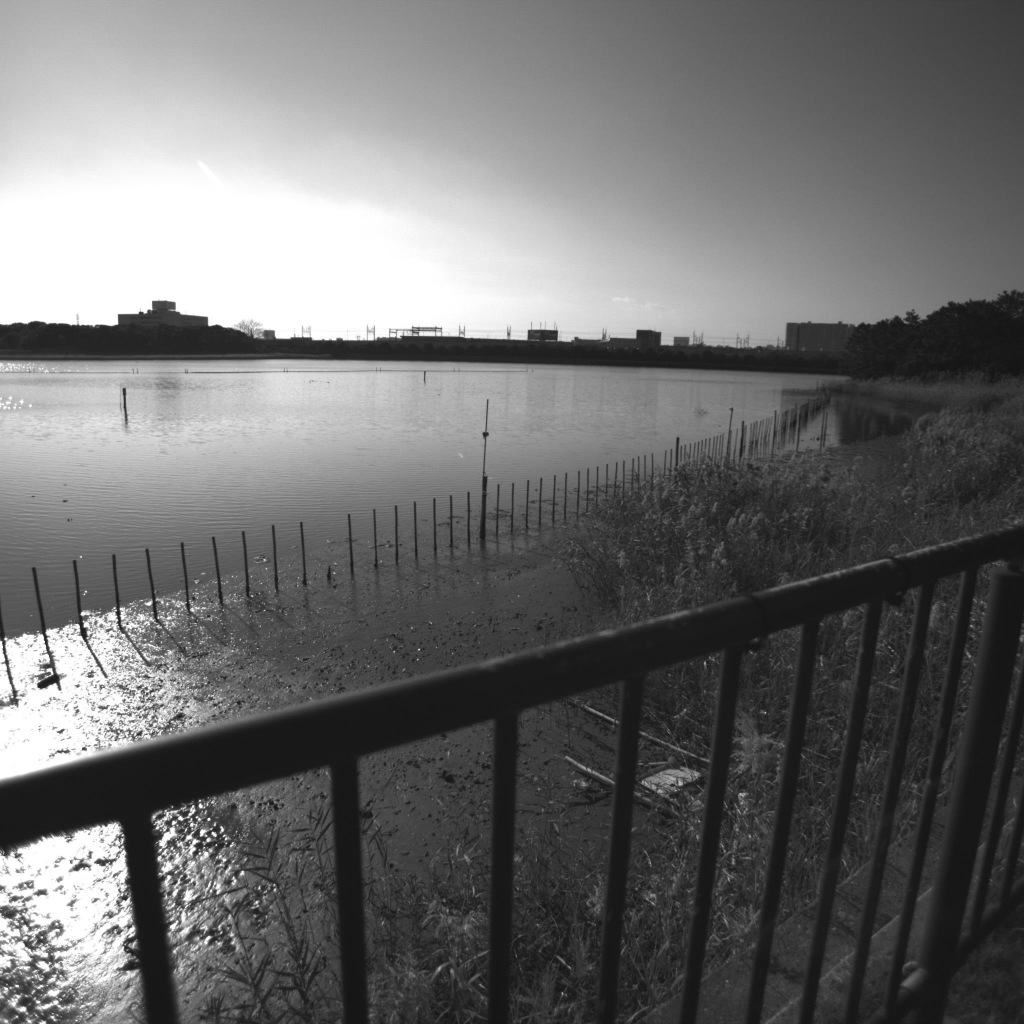

In [0]:
for img in image_frames:
  imshow_resized(img, 0.5)
  break